In [1]:
import math
import tqdm
import itertools
import copy
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import laplace_approximation
import layers
import losses
import likelihoods
import priors
import utils

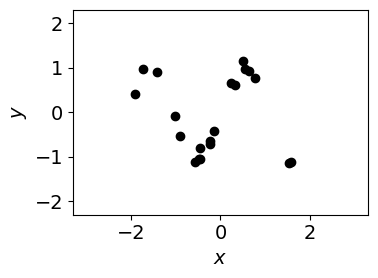

In [3]:
N = 20
random_state = np.random.RandomState(42)
X_numpy = random_state.randn(N, 1)
y_numpy = np.sin(3 * X_numpy) + 0.1 * random_state.randn(N, 1)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
dataloader_batch_size1 = torch.utils.data.DataLoader(dataset, batch_size=1)

#X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
#y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-2.3, 2.3])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [26]:
model = layers.RandomFourierFeaturesGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, lengthscale=1.0, learnable_outputscale=True)
init_state_dict = copy.deepcopy(model.state_dict())
model.load_state_dict(init_state_dict)
likelihood = likelihoods.GaussianLikelihood(learnable_noise=True, num_classes=1)
prior = priors.IsotropicGaussianPrior(num_params=len(utils.flatten_params(model)))

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

B, F, K, gamma = 0, 1, 1, 1.0
la = laplace_approximation.DiagEFLaplace(model, likelihood, prior)

criterion = losses.MAPLoss(likelihood, prior)

best_train_loss = float("inf")
best_state_dict = None
best_model_history_df = None

for lr in [0.1, 0.01, 0.001, 0.0001]:
        
    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer_params = torch.optim.Adam([{"params": model.linear.parameters()},], lr=lr)
    optimizer_hypers = torch.optim.Adam([{"params": [model.raw_lengthscale, model.raw_outputscale]}, {"params": likelihood.parameters()},], lr=lr)

    columns = ["epoch", "gamma", "lengthscale", "lr", "map_loss", "lml_loss", "noise", "outputscale"]
    model_history_df = pd.DataFrame(columns=columns)
    
    lml_metrics = {"loss": float("nan")}
    
    for epoch in tqdm.tqdm(range(1_000)):
        
        map_metrics = utils.train_one_epoch(model, criterion, optimizer_params, dataloader)
        
        if (epoch + 1) > B and (epoch + 1) % F == 0:
            la._compute_H(dataloader_batch_size1)
            for _ in range(K):
                lml_metrics = utils.train_one_epoch(model, la.lml_loss, optimizer_hypers, dataloader)
                
                row = [epoch, gamma, model.lengthscale.item(), lr, map_metrics["loss"], lml_metrics["loss"], likelihood.noise.item(), model.outputscale.item()]
                model_history_df.loc[len(model_history_df)] = row
                
                if lml_metrics["loss"] < best_train_loss:
                    best_train_loss = lml_metrics["loss"]
                    best_state_dict = {
                        "model": model.state_dict(),
                        "likelihood": likelihood.state_dict(),
                        "prior": prior.state_dict(),
                    }
                    best_model_history_df = model_history_df

        row = [epoch, gamma, model.lengthscale.item(), lr, map_metrics["loss"],  lml_metrics["loss"], likelihood.noise.item(), model.outputscale.item()]
        model_history_df.loc[len(model_history_df)] = row
                    
model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    la_mean = model(linspace).view(-1)
    la_samples = torch.stack([la.sample_forward(linspace).view(-1) + likelihood.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(la_mean, "regression_la_mean.pt")
    torch.save(la_samples, "regression_la_samples.pt")

100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s]


In [5]:
def clml(model, likelihood, prior, Sigma_post, X, y):
    N, C = X.shape
    features = model.featurize(X)
    logits = model.linear(features)
    Phi = features.T
    cov = likelihood.noise**2 * torch.eye(N) + prior.tau * Phi.T @ Sigma_post @ Phi
    cov_inv = torch.inverse(cov)
    norm_const = -0.5 * N * math.log(2 * math.pi)
    log_det = -0.5 * torch.logdet(cov)
    quad_term = -0.5 * (y - logits).T @ cov_inv @ (y - logits)
    clml = norm_const + log_det + quad_term
    return -clml

indices = torch.arange(N)
n1, n2 = int(0.6 * N), int(0.8 * N)
X_cond80, y_cond80 = X[indices[:n1]], y[indices[:n1]]
X_eval5, y_eval5 = X[indices[n1:n2]], y[indices[n1:n2]]
X_eval15, y_eval15 = X[indices[n2:]], y[indices[n2:]]
cond80_dataset = torch.utils.data.TensorDataset(X_cond80, y_cond80)
cond80_dataloader = torch.utils.data.DataLoader(cond80_dataset, batch_size=len(cond80_dataset))
cond80_dataloader_batch_size1 = torch.utils.data.DataLoader(cond80_dataset, batch_size=1)

model = layers.RandomFourierFeaturesGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, lengthscale=1.0, learnable_outputscale=True)
model.load_state_dict(init_state_dict)
likelihood = likelihoods.GaussianLikelihood(learnable_noise=True, num_classes=1)
prior = priors.IsotropicGaussianPrior(num_params=len(utils.flatten_params(model)))

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

B, F, K, gamma = 9_999, 1, 1_000, 1.0
la = laplace_approximation.DiagEFLaplace(model, likelihood, prior)

criterion = losses.MAPLoss(likelihood, prior)

best_train_loss = float("inf")
best_state_dict = None
best_model_history_df = None

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer_params = torch.optim.Adam([{"params": model.linear.parameters()},], lr=lr)
    optimizer_hypers = torch.optim.Adam([{"params": [model.raw_lengthscale, model.raw_outputscale]}, {"params": likelihood.parameters()},], lr=gamma)

    columns = ["epoch", "gamma", "lengthscale", "lr", "map_loss", "clml_loss", "noise", "outputscale"]
    model_history_df = pd.DataFrame(columns=columns)
    
    loss = torch.tensor(float("nan"))
    
    for epoch in tqdm.tqdm(range(10_000)):
        
        map_metrics = utils.train_one_epoch(model, criterion, optimizer_params, cond80_dataloader)
        
        #row = [epoch, gamma, model.lengthscale.item(), lr, map_metrics["loss"],  lml_metrics["loss"], likelihood.noise.item(), model.outputscale.item()]
        #model_history_df.loc[len(model_history_df)] = row
        
        if (epoch + 1) > B and (epoch + 1) % F == 0:
            
            la._compute_H(cond80_dataloader_batch_size1)
            
            best_temp = None
            best_bma_nll = np.inf
            for temp in [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
                la.temp = temp
                bma_nll = torch.stack([likelihood(la.sample_forward(X_eval5), y_eval5) for _ in range(20)]).mean(dim=0)
                if bma_nll < best_bma_nll:
                    best_temp = temp
                    best_bma_nll = bma_nll
            la.temp = best_temp
            
            for _ in range(K):
                
                optimizer_hypers.zero_grad()
                loss = clml(model, likelihood, prior, la.temp * la.H.diag(), X_eval15, y_eval15).sum()
                #log_probs_arrays = [likelihood(la.sample_forward(X_eval15), y_eval15, reduction="sum") for _ in range(20)]
                #clml = torch.logsumexp(torch.stack(log_probs_arrays), dim=0) - np.log(len(log_probs_arrays))
                #loss = (1 / len(X_eval15)) * -clml
                loss.backward()
                for group in optimizer_hypers.param_groups:
                    torch.nn.utils.clip_grad_norm_(group["params"], max_norm=1.0)
                optimizer_hypers.step()
                
                row = [epoch, gamma, model.lengthscale.item(), lr, map_metrics["loss"], loss.item(), likelihood.noise.item(), model.outputscale.item()]
                model_history_df.loc[len(model_history_df)] = row
        
        if loss.item() < best_train_loss:
            best_train_loss = loss.item()
            best_state_dict = {
                "model": model.state_dict(),
                "likelihood": likelihood.state_dict(),
                "prior": prior.state_dict(),
            }
            best_model_history_df = model_history_df
            
model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    clml_mean = model(linspace).view(-1)
    clml_samples = torch.stack([la.sample_forward(linspace).view(-1) + likelihood.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(clml_mean, "regression_clml_mean.pt")
    torch.save(clml_samples, "regression_clml_samples.pt")

100%|██████████| 10000/10000 [00:24<00:00, 406.28it/s]


In [11]:
model = layers.RandomFourierFeaturesGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, lengthscale=20.0, learnable_outputscale=True)
model.load_state_dict(init_state_dict)
#model.raw_lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(20.0))))
model.raw_sigma = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.raw_sigma)
#utils.add_variational_layers(model, None)
#model.raw_sigma = torch.nn.Parameter(math.log(math.expm1(1e-4)) * torch.ones_like(utils.flatten_params(model)))
#utils.assign_diag_raw_sigma(model, model.raw_sigma)
model.use_posterior = types.MethodType(utils.use_posterior, model)
likelihood = likelihoods.GaussianLikelihood(learnable_noise=True, num_classes=1)
prior = priors.IsotropicGaussianPrior(num_params=len(utils.flatten_params(model)))

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

criterion = losses.TemperedELBOLoss(model, likelihood, prior, kappa=1.0)

best_state_dict = None
best_train_loss = float("inf")
best_model_history_df = None

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer_params = torch.optim.Adam([{"params": model.parameters()}, {"params": likelihood.parameters()},], lr=lr)

    columns = ["epoch", "lengthscale", "lr", "noise", "outputscale", "train_loss"]
    model_history_df = pd.DataFrame(columns=columns)
    
    for epoch in tqdm.tqdm(range(10_000)):
        
        train_metrics = utils.train_one_epoch(model, criterion, optimizer_params, dataloader, num_samples=5)
                
        row = [epoch, model.lengthscale.item(), lr, likelihood.noise.item(), model.outputscale.item(), train_metrics["loss"]]
        model_history_df.loc[len(model_history_df)] = row
        
    if train_metrics["loss"] < best_train_loss:
        best_state_dict = {
            "model": model.state_dict(),
            "likelihood": likelihood.state_dict(),
            "prior": prior.state_dict(),
        }
        best_train_loss = train_metrics["loss"]
        best_model_history_df = model_history_df

model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    elbo_mean = model(linspace).view(-1)
    model.use_posterior(True)
    elbo_samples = torch.stack([model(linspace).view(-1) + likelihood.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(elbo_mean, "regression_elbo_mean.pt")
    torch.save(elbo_samples, "regression_elbo_samples.pt")

100%|██████████| 10000/10000 [01:45<00:00, 94.79it/s]


In [28]:
model = layers.RandomFourierFeaturesGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, lengthscale=1.0, learnable_outputscale=True)
model.load_state_dict(init_state_dict)
#model.raw_lengthscale = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(20.0))))
model.raw_sigma = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.raw_sigma)
#utils.add_variational_layers(model, None)
#model.raw_sigma = torch.nn.Parameter(math.log(math.expm1(1e-4)) * torch.ones_like(utils.flatten_params(model)))
#utils.assign_diag_raw_sigma(model, model.raw_sigma)
model.use_posterior = types.MethodType(utils.use_posterior, model)
likelihood = likelihoods.GaussianLikelihood(learnable_noise=True, num_classes=1)
prior = priors.IsotropicGaussianPrior(num_params=len(utils.flatten_params(model)))

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

criterion = losses.TemperedELBOLoss(model, likelihood, prior, kappa=len(utils.flatten_params(model))/(2*len(X)))

best_state_dict = None
best_train_loss = float("inf")
best_model_history_df = None

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer_params = torch.optim.Adam([{"params": model.parameters()}, {"params": likelihood.parameters()},], lr=lr)

    columns = ["epoch", "lengthscale", "lr", "noise", "outputscale", "train_loss"]
    model_history_df = pd.DataFrame(columns=columns)
    
    for epoch in tqdm.tqdm(range(10_000)):
        
        train_metrics = utils.train_one_epoch(model, criterion, optimizer_params, dataloader, num_samples=5)
                
        row = [epoch, model.lengthscale.item(), lr, likelihood.noise.item(), model.outputscale.item(), train_metrics["loss"]]
        model_history_df.loc[len(model_history_df)] = row
        
    if train_metrics["loss"] < best_train_loss:
        best_state_dict = {
            "model": model.state_dict(),
            "likelihood": likelihood.state_dict(),
            "prior": prior.state_dict(),
        }
        best_train_loss = train_metrics["loss"]
        best_model_history_df = model_history_df

model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])
model.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    deelbo_mean = model(linspace).view(-1)
    model.use_posterior(True)
    deelbo_samples = torch.stack([model(linspace).view(-1) + likelihood.noise * torch.randn((1000,)) for _ in range(10_000)])
    torch.save(deelbo_mean, "regression_deelbo_mean.pt")
    torch.save(deelbo_samples, "regression_deelbo_samples.pt")

  2%|▏         | 196/10000 [00:02<01:46, 91.85it/s]

KeyboardInterrupt



In [8]:
def lml_loss(model, likelihood, prior, X, y):
    N, C = X.shape
    Phi = model.featurize(X).T
    cov = likelihood.noise**2 * torch.eye(N) + prior.tau * Phi.T @ Phi
    cov_inv = torch.inverse(cov)
    norm_const = -0.5 * N * math.log(2 * math.pi)
    log_det = -0.5 * torch.logdet(cov)
    quad_term = -0.5 * y.T @ cov_inv @ y
    lml = norm_const + log_det + quad_term
    return -lml

def posterior(model, likelihood, prior, X, y):
    Phi = model.featurize(X).T    
    R, N = Phi.shape
    cov = torch.inverse(prior.tau * torch.eye(R) + Phi @ torch.inverse(likelihood.noise**2 * torch.eye(N)) @ Phi.T)
    mu = cov @ (Phi @ torch.inverse(likelihood.noise**2 * torch.eye(N)) @ y)
    return mu, cov

def closure():
    optimizer.zero_grad()
    loss = lml_loss(model, likelihood, prior, X, y)
    loss.backward()
    return loss

model = layers.RandomFourierFeaturesGaussianProcess(in_features=1, out_features=1, learnable_lengthscale=True, lengthscale=1.0, learnable_outputscale=True)
model.load_state_dict(init_state_dict)
likelihood = likelihoods.GaussianLikelihood(learnable_noise=True, num_classes=1)
prior = priors.IsotropicGaussianPrior(num_params=len(utils.flatten_params(model)))

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

best_train_loss = float("inf")
best_state_dict = None

for lr in [0.1, 0.01, 0.001, 0.0001]:

    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])

    optimizer = torch.optim.LBFGS(list(model.parameters()) + list(likelihood.parameters()), lr=lr, max_iter=10_000, line_search_fn="strong_wolfe")
    loss = optimizer.step(lambda: closure())

    if loss.item() < best_train_loss:
        best_state_dict = {
            "model": model.state_dict(),
            "likelihood": likelihood.state_dict(),
            "prior": prior.state_dict(),
        }
        best_train_loss = loss.item()

model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])
model.eval()

mu_post, Sigma_post = posterior(model, likelihood, prior, X, y)
L_post = torch.linalg.cholesky(Sigma_post)
posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_post.view(-1), scale_tril=L_post)

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000).view(-1, 1)
    model.linear.weight.data = mu_post.view(1, -1)
    lml_mean = model(linspace).view(-1)
    lml_samples = []
    for _ in tqdm.tqdm(range(1_000)):
        model.linear.weight.data = posterior.sample().view(1, -1)
        lml_samples.append(model(linspace).view(-1) + likelihood.noise * torch.randn((1000,)))
    lml_samples = torch.stack(lml_samples)
    torch.save(lml_mean, "regression_lml_mean.pt")
    torch.save(lml_samples, "regression_lml_samples.pt")    

100%|██████████| 1000/1000 [00:00<00:00, 1042.16it/s]


In [29]:
la_mean = torch.load("regression_la_mean.pt", weights_only=False)
la_samples = torch.load("regression_la_samples.pt", weights_only=False)
clml_mean = torch.load("regression_clml_mean.pt", weights_only=False)
clml_samples = torch.load("regression_clml_samples.pt", weights_only=False)
elbo_mean = torch.load("regression_elbo_mean.pt", weights_only=False)
elbo_samples = torch.load("regression_elbo_samples.pt", weights_only=False)
deelbo_mean = torch.load("regression_deelbo_mean.pt", weights_only=False)
deelbo_samples = torch.load("regression_deelbo_samples.pt", weights_only=False)
lml_mean = torch.load("regression_lml_mean.pt", weights_only=False)
lml_samples = torch.load("regression_lml_samples.pt", weights_only=False)

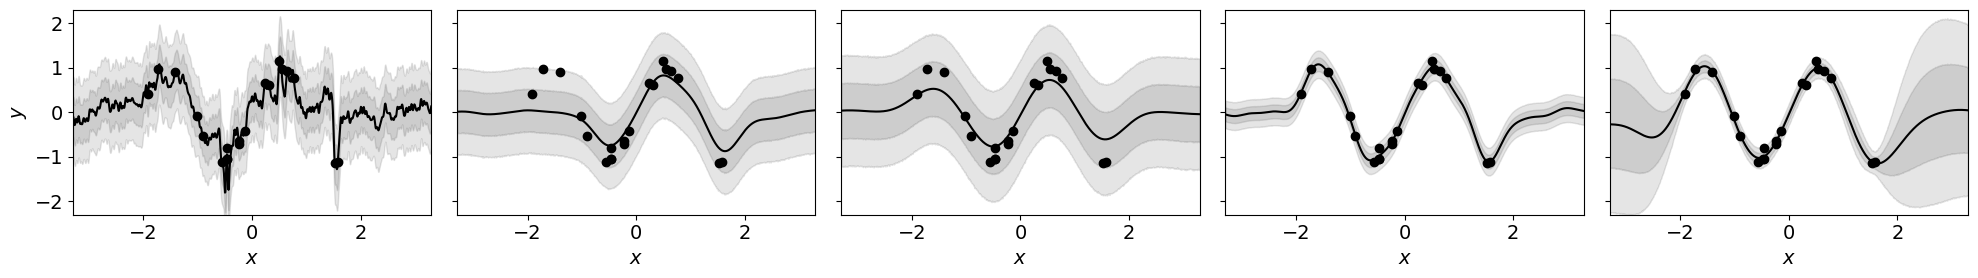

In [30]:
linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color="#000000")
axs[0].fill_between(linspace, la_samples.mean(dim=0) + 2 * la_samples.std(dim=0), la_samples.mean(dim=0) - 2 * la_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].fill_between(linspace, la_samples.mean(dim=0) + 1 * la_samples.std(dim=0), la_samples.mean(dim=0) - 1 * la_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].plot(linspace, la_mean, color="#000000")
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")

axs[1].scatter(X_numpy, y_numpy, color="#000000")
axs[1].fill_between(linspace, clml_samples.mean(dim=0) + 2 * clml_samples.std(dim=0), clml_samples.mean(dim=0) - 2 * clml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].fill_between(linspace, clml_samples.mean(dim=0) + 1 * clml_samples.std(dim=0), clml_samples.mean(dim=0) - 1 * clml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].plot(linspace, clml_mean, color="#000000")
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_xlabel(r"$x$")

axs[2].scatter(X_numpy, y_numpy, color="#000000")
axs[2].fill_between(linspace, elbo_samples.mean(dim=0) + 2 * elbo_samples.std(dim=0), elbo_samples.mean(dim=0) - 2 * elbo_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].fill_between(linspace, elbo_samples.mean(dim=0) + 1 * elbo_samples.std(dim=0), elbo_samples.mean(dim=0) - 1 * elbo_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].plot(linspace, elbo_mean, color="#000000")
axs[2].set_xlim([-3.3, 3.3])
axs[2].set_ylim([-2.3, 2.3])
axs[2].set_xlabel(r"$x$")

axs[3].scatter(X_numpy, y_numpy, color="#000000")
axs[3].fill_between(linspace, deelbo_samples.mean(dim=0) + 2 * deelbo_samples.std(dim=0), deelbo_samples.mean(dim=0) - 2 * deelbo_samples.std(dim=0), alpha=0.1, color="#000000")
axs[3].fill_between(linspace, deelbo_samples.mean(dim=0) + 1 * deelbo_samples.std(dim=0), deelbo_samples.mean(dim=0) - 1 * deelbo_samples.std(dim=0), alpha=0.1, color="#000000")
axs[3].plot(linspace, deelbo_mean, color="#000000")
axs[3].set_xlim([-3.3, 3.3])
axs[3].set_ylim([-2.3, 2.3])
axs[3].set_xlabel(r"$x$")

axs[4].scatter(X_numpy, y_numpy, color="#000000")
axs[4].fill_between(linspace, lml_samples.mean(dim=0) + 2 * lml_samples.std(dim=0), lml_samples.mean(dim=0) - 2 * lml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[4].fill_between(linspace, lml_samples.mean(dim=0) + 1 * lml_samples.std(dim=0), lml_samples.mean(dim=0) - 1 * lml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[4].plot(linspace, lml_mean, color="#000000")
axs[4].set_xlim([-3.3, 3.3])
axs[4].set_ylim([-2.3, 2.3])
axs[4].set_xlabel(r"$x$")

fig.tight_layout()
fig.savefig("regression_demo.pdf", bbox_inches="tight")
plt.show()

In [15]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y.view(-1), likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
}

model.train()
likelihood.train()

best_state_dict = None
best_train_loss = float("inf")

for lr in [0.1, 0.01, 0.001, 0.0001]:
    
    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in tqdm.tqdm(range(1_000)):
        
        optimizer.zero_grad()
        output = model(X)
        loss = (1 / N) * -mll(output, y.view(-1)).sum()
        loss.backward()
        optimizer.step()
    
    if loss.item() < best_train_loss:
        best_state_dict = {
            "model": model.state_dict(),
            "likelihood": likelihood.state_dict(),
        }
        best_train_loss = loss.item()

model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
model.eval()
likelihood.eval()

with torch.no_grad():
    linspace = torch.linspace(start=-3.3, end=3.3, steps=1000)
    gp_preds = likelihood(model(linspace))
    gp_samples = gp_preds.sample(torch.Size((3,)))
    torch.save(gp_preds, 'regression_gp_preds.pt')
    torch.save(gp_samples, 'regression_gp_samples.pt')

100%|██████████| 1000/1000 [00:02<00:00, 374.21it/s]


In [16]:
lml_mean = torch.load("regression_lml_mean.pt", weights_only=False)
lml_samples = torch.load("regression_lml_samples.pt", weights_only=False)
gp_preds = torch.load("regression_gp_preds.pt", weights_only=False)
gp_samples = torch.load("regression_gp_samples.pt", weights_only=False)

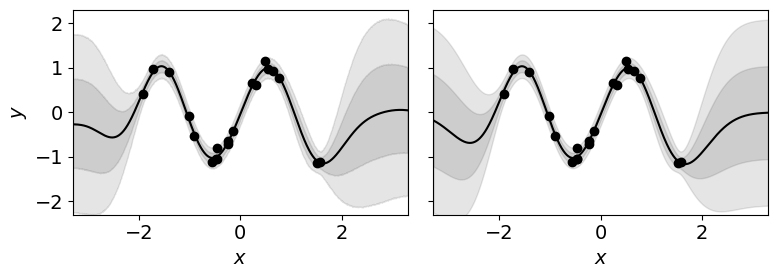

In [17]:
linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy, y_numpy, color="#000000")
axs[0].fill_between(linspace, lml_samples.mean(dim=0) + 2 * lml_samples.std(dim=0), lml_samples.mean(dim=0) - 2 * lml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].fill_between(linspace, lml_samples.mean(dim=0) + 1 * lml_samples.std(dim=0), lml_samples.mean(dim=0) - 1 * lml_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].plot(linspace, lml_mean, color="#000000")
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")

axs[1].scatter(X_numpy, y_numpy, color="#000000")
axs[1].fill_between(linspace, gp_preds.mean + 2 * gp_preds.stddev, gp_preds.mean - 2 * gp_preds.stddev, alpha=0.1, color="#000000")
axs[1].fill_between(linspace, gp_preds.mean + 1 * gp_preds.stddev, gp_preds.mean - 1 * gp_preds.stddev, alpha=0.1, color="#000000")
#axs[1].plot(linspace, gp_samples[0], color="#D62728")
#axs[1].plot(linspace, gp_samples[1], color="#1F77B4")
#axs[1].plot(linspace, gp_samples[2], color="#2CA02C")
axs[1].plot(linspace, gp_preds.mean, color="#000000")
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_xlabel(r"$x$")

fig.tight_layout()
fig.savefig("rff_gp_comparison.pdf", bbox_inches="tight")
plt.show()